# Naive Bayes

In [1]:
# Import packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [2]:
# Read dataset
data_raw = pd.read_csv("data_raw.csv")


# Basic cleaning
data_clean = data_raw.replace("#NAME?", "")
data_clean = data_clean.fillna("")
data_clean.columns = ["id", "t1", "n1", "c1", "n2", "c2", "t2", "n3", "n4", "t3", "label"]

data_vec = data_clean[["id"]].copy()

In [3]:
# Vectorize `choice` columns
option = ["computation", "code", "analysis", "concept", "format", "essay", "text", "idea"]

for i in range(1, 3):
    for opt in option:
        data_vec[f"c{i}_{opt}"] = data_clean[f"c{1}"].str.contains(opt).astype(int)


# Vectorize `text` columns
for i in range(1, 4):
    vec = CountVectorizer(max_features=3000, binary=True)
    t_mat = vec.fit_transform(data_clean[f"t{i}"])
    
    col = []
    for word in vec.get_feature_names_out():
        col.append(f"t{i}_{word}")
    data_t = pd.DataFrame(t_mat.toarray(), columns=col)
    data_vec = pd.concat([data_vec, data_t], axis=1)


# Categorize `label` column
data_vec["label"] = pd.factorize(data_clean["label"])[0]


# Write cleaned dataset to .csv file
data_vec.to_csv("data_vec.csv", index=False)

In [4]:
# Split data (68%-16%-16%)
random.seed(311)
stud = data_vec["id"].unique().tolist()
random.shuffle(stud)
train, valid, test = stud[:187], stud[187:231], stud[231:]

data_train = data_vec[data_vec["id"].isin(train)]
data_valid = data_vec[data_vec["id"].isin(valid)]
data_test = data_vec[data_vec["id"].isin(test)]

X_train, t_train = data_train.drop(["id", "label"], axis=1).values, data_train["label"].values
X_valid, t_valid = data_valid.drop(["id", "label"], axis=1).values, data_valid["label"].values
X_test, t_test = data_test.drop(["id", "label"], axis=1).values, data_test["label"].values

In [5]:
# Training
def nb_map3(X, t, a, b):
    N, pi, N_t, theta = X.shape[0], np.zeros(3), np.zeros(3), np.zeros([X.shape[1], 3])
    
    for i in range(3):
        N_i, X_i = np.sum(t == i), X[t == i]
        N_t[i] = N_i
        pi[i] = (a + N_i - 1) / (a + b + N - 2)
        theta[:, i] = (a + np.sum(X_i, axis=0) - 1) / (a + b + X_i.shape[0] - 2)
    
    return pi, theta


# Prediction
def pred3(X, pi, theta):
    log_p = np.zeros((X.shape[0], 3))
    for i in range(3):
        log_p[:, i] = np.log(pi[i]) + X @ np.log(theta[:, i]) + (1 - X) @ np.log(1 - theta[:, i])

    return np.argmax(log_p, axis=1)


# Compute accuracy
def acc(y, t):
    return np.mean(y == t)

In [6]:
# Plot accuracy matrix
def plot_acc(acc_mat, values, title):
    acc_max, acc_min = np.max(acc_mat), np.min(acc_mat)
    spd = acc_max - acc_min
    
    plt.figure(figsize=(12, 10))
    plt.imshow(acc_mat, cmap="RdYlGn_r")
    
    for i in range(len(values)):
        for j in range(len(values)):
            val = acc_mat[i, j]
            if val == acc_max:
                a_opt, b_opt = values[i], values[j]
            if spd * 0.15 < val - acc_min < spd * 0.85:
                c = "black"
            else:
                c = "white"
            plt.text(j, i, f"{acc_mat[i, j]:.3f}", ha="center", va="center", color=c)
    
    plt.xticks(range(len(values)), values)
    plt.yticks(range(len(values)), values)
    plt.xlabel("b")
    plt.ylabel("a")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
    return a_opt, b_opt, acc_max


# Plot confusion matrix
def plot_cm(cm, title):
    models = ["ChatGPT", "Claude", "Gemini"]
    n_max, n_min = np.max(cm), np.min(cm)
    spd = n_max - n_min
    
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Purples")

    for i in range(3):
        for j in range(3):
            n = cm[i, j]
            if n < spd * 0.5 + n_min:
                c = "black"
            else:
                c = "white"
            plt.text(j, i, f"{n}", ha="center", va="center", fontweight="bold", color=c)

    plt.xticks(range(3), models)
    plt.yticks(range(3), models)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.colorbar()
    plt.show()

In [7]:
# Hyperparameter tuning
values = [1.1, 1.2, 1.3, 1.4, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 5.0, 7.5, 10.0]
n = len(values)
acc_train, acc_valid = np.zeros((n, n)), np.zeros((n, n))

for i in range(n):
    for j in range(n):
        pi, theta = nb_map3(X_train, t_train, values[i], values[j])
        y_train = pred3(X_train, pi, theta)
        acc_train[i, j] = acc(y_train, t_train)
        y_valid = pred3(X_valid, pi, theta)
        acc_valid[i, j] = acc(y_valid, t_valid)

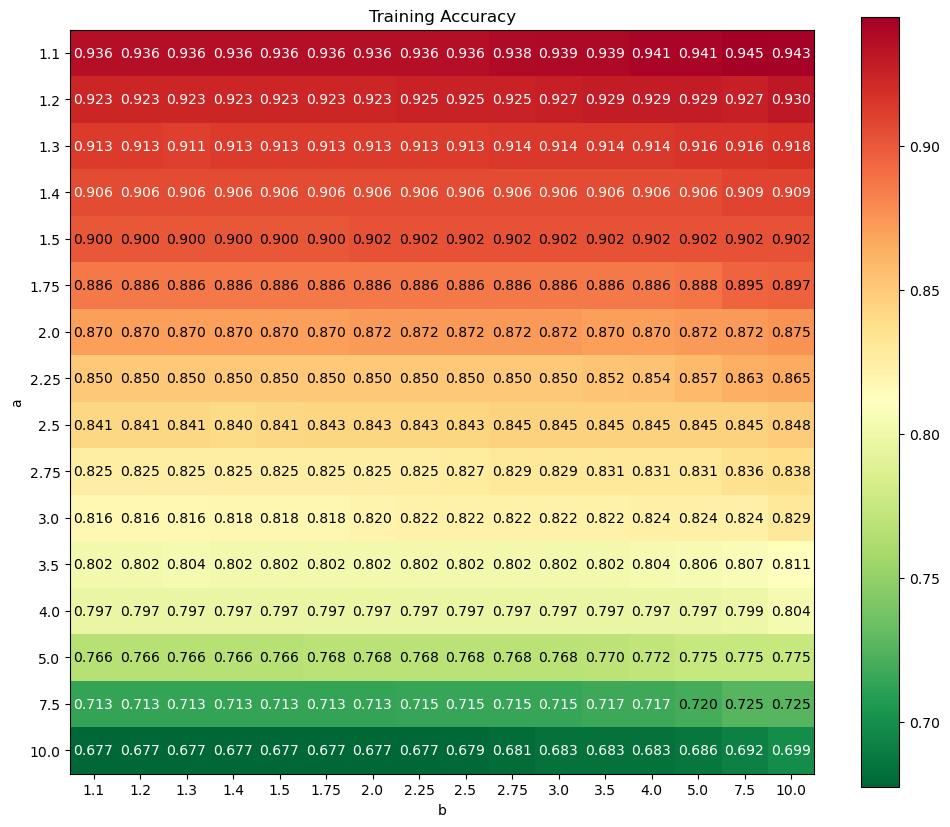

Optimal `a`: 1.1.
Optimal `b`: 7.5.
Optimal accuracy: 0.945.


In [8]:
# Plot training accuracy matrix
a_opt_test, b_opt_test, acc_max_test = plot_acc(acc_train, values, "Training Accuracy")
print(f"Optimal `a`: {a_opt_test}.")
print(f"Optimal `b`: {b_opt_test}.")
print(f"Optimal accuracy: {acc_max_test:.3f}.")

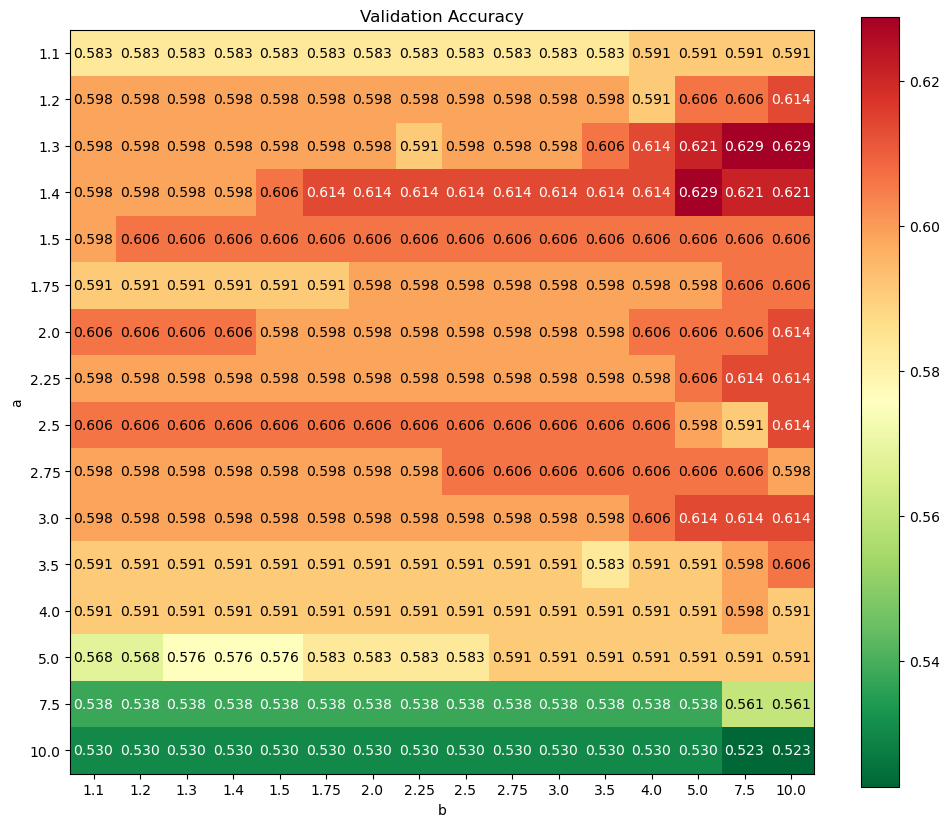

Optimal `a`: 1.4.
Optimal `b`: 5.0.
Optimal accuracy: 0.629.


In [9]:
# Plot validation accuracy matrix
a_opt_valid, b_opt_valid, acc_max_valid = plot_acc(acc_valid, values, "Validation Accuracy")
print(f"Optimal `a`: {a_opt_valid}.")
print(f"Optimal `b`: {b_opt_valid}.")
print(f"Optimal accuracy: {acc_max_valid:.3f}.")

Testing accuracy: 0.6060606060606061.


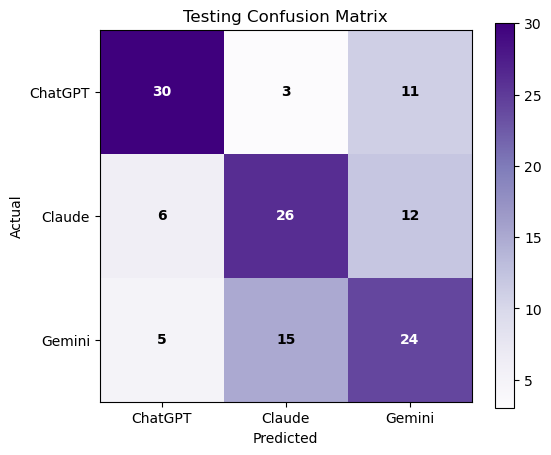

In [10]:
# Testing
pi, theta = nb_map3(X_train, t_train, a_opt_valid, b_opt_valid)
y_test = pred3(X_test, pi, theta)
acc_test = acc(y_test, t_test)
print(f"Testing accuracy: {acc_test}.")
plot_cm(confusion_matrix(t_test, y_test), "Testing Confusion Matrix")